In [1]:
import pandas as pd
import glob
import statsmodels.api as sm
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
archivos = glob.glob('dataset/*.csv') #agrupo todos los csv
archivos_ordenados = sorted(archivos, key=lambda x: x.split('_')[3]) #ordeno por YYYMM de forma asc

In [3]:
dataframes = []
for archivo in archivos_ordenados: # junto todos los csv
    df = pd.read_csv(archivo, header=None, sep=';')
    dataframes.append(df)

data = pd.concat(dataframes, ignore_index=True)

nombres_columnas = ['ID', 'Date', 'Consumo', 'Flag', 'Muestra', 'Nombre_Interruptor']
data.columns = nombres_columnas + list(range(len(nombres_columnas), len(data.columns)))

In [4]:
def remove_timezone(date_str):
    return re.sub(r'\s*[-+]\d{4}', '', date_str)
data["Date"] = data["Date"].apply(remove_timezone)
data["Date"] = pd.to_datetime(data["Date"], format="%Y-%m-%d %H:%M:%S")


In [5]:
valores_faltantes = data.isnull().sum()
proporcion_faltantes = valores_faltantes / len(data) * 100
print("Valores faltantes por columna:")
print(proporcion_faltantes)

# Identificar las columnas con valores faltantes
columnas_con_faltantes = valores_faltantes[valores_faltantes > 0].index.tolist()
print("\nColumnas con valores faltantes:")
print(columnas_con_faltantes)

# Evaluar el impacto de los valores faltantes en tu análisis
# Aquí puedes realizar análisis específicos para cada columna con valores faltantes y determinar su importancia

# Considerar estrategias para manejar los valores faltantes
# Por ejemplo, puedes imputar los valores faltantes con la media o la mediana de la columna, eliminar filas con valores faltantes, etc.
# Aquí hay un ejemplo de imputación de valores faltantes con la media de la columna "columna_con_faltantes":
datos_imputados = data.copy()
for columna in columnas_con_faltantes:
    media = data[columna].mean()
    datos_imputados[columna].fillna(media, inplace=True)

Valores faltantes por columna:
ID                    0.0
Date                  0.0
Consumo               0.0
Flag                  0.0
Muestra               0.0
Nombre_Interruptor    0.0
dtype: float64

Columnas con valores faltantes:
[]


In [6]:
data.head(10)


,ID,Date,Consumo,Flag,Muestra,Nombre_Interruptor
0,177760211,2017-02-28 15:00:00,-28.206767,1,4,AJAHUEL 110 H1 P
1,395102211,2017-02-28 15:00:00,-236.467353,1,4,BUIN 110 HT1 MTP
2,395684211,2017-02-28 15:00:00,126.075465,1,4,BUIN 110 H2 P
3,397670211,2017-02-28 15:00:00,81.017303,1,4,LOSALME 110 H1 P
4,397693211,2017-02-28 15:00:00,69.876691,1,4,LOSALME 110 H3 P
5,397712211,2017-02-28 15:00:00,74.248916,1,4,LOSALME 110 H4 P
6,400203211,2017-02-28 15:00:00,30.345499,1,4,LOSALME 110 H2 P
7,433388211,2017-02-28 15:00:00,158.178446,1,4,CHENA 110 H1 P
8,393655211,2017-02-28 15:00:00,109.541742,1,4,BUIN 110 H1 P
9,433398211,2017-02-28 15:00:00,129.607846,1,4,CHENA 110 H2 P


In [7]:
split_data = data['Nombre_Interruptor'].str.split()

data['Barra'] = split_data.str[0]
data['Subestacion'] = split_data.str[1].str.join(' ')
data['Interruptor'] = split_data.str[2:].str.join(' ')

data.drop(columns=['Nombre_Interruptor'], inplace=True)

In [8]:
data

,ID,Date,Consumo,Flag,Muestra,Barra,Subestacion,Interruptor
0,177760211,2017-02-28 15:00:00,-28.206767,1,4,AJAHUEL,1 1 0,H1 P
1,395102211,2017-02-28 15:00:00,-236.467353,1,4,BUIN,1 1 0,HT1 MTP
2,395684211,2017-02-28 15:00:00,126.075465,1,4,BUIN,1 1 0,H2 P
3,397670211,2017-02-28 15:00:00,81.017303,1,4,LOSALME,1 1 0,H1 P
4,397693211,2017-02-28 15:00:00,69.876691,1,4,LOSALME,1 1 0,H3 P
...,...,...,...,...,...,...,...,...
2242963,387377211,2023-06-27 23:00:00,9.554752,1,4,FLORIDA,1 1 0,H3 P
2242964,387401211,2023-06-27 23:00:00,-24.972685,1,4,FLORIDA,1 1 0,H4 P
2242965,392490211,2023-06-27 23:00:00,-39.438634,1,4,FLORIDA,1 1 0,H8 P
2242966,392509211,2023-06-27 23:00:00,37.972639,1,4,FLORIDA,1 1 0,H7 P


In [9]:
# Verificar la consistencia de los datos en cada columna
consistencia_columnas = data.apply(lambda x: x.nunique())
print("Número de valores únicos por columna:")
print(consistencia_columnas)


Número de valores únicos por columna:
ID                  39
Date             55296
Consumo        1970970
Flag                 3
Muestra              5
Barra                7
Subestacion          1
Interruptor         12
dtype: int64


In [10]:
# Realizar análisis estadístico para identificar datos atípicos
analisis_estadistico = data.describe()
print("Análisis estadístico de los datos:")
print(analisis_estadistico)


Análisis estadístico de los datos:
                 ID                           Date       Consumo  \
count  2.242968e+06                        2242968  2.242968e+06   
mean   3.617996e+08  2020-05-25 17:45:27.354291456  3.233541e+01   
min    1.777602e+08            2017-02-28 15:00:00 -5.970000e+02   
25%    2.255402e+08            2018-10-21 05:45:00 -3.062436e+00   
50%    3.925612e+08            2020-06-11 06:30:00  4.379763e+01   
75%    4.333882e+08            2022-02-05 23:15:00  8.145555e+01   
max    8.546412e+08            2023-06-27 23:00:00  3.199903e+02   
std    1.257530e+08                            NaN  7.411118e+01   

               Flag       Muestra  
count  2.242968e+06  2.242968e+06  
mean   9.889330e-01  3.940358e+00  
min    0.000000e+00  0.000000e+00  
25%    1.000000e+00  4.000000e+00  
50%    1.000000e+00  4.000000e+00  
75%    1.000000e+00  4.000000e+00  
max    3.300000e+01  4.000000e+00  
std    5.571145e-01  4.551701e-01  


In [11]:
valor_minimo = data['Consumo'].min()
print(f'Valor Mínimo: {valor_minimo}')
valor_maximo = data['Consumo'].max()
print(f'Valor Máximo: {valor_maximo}')
columna_especifica = data['Consumo']
rangos_validos = (data['Consumo'] >= valor_minimo) & (data['Consumo'] <= valor_maximo)
datos_inconsistentes = data[~rangos_validos]
print(f'Datos columna Consumo:')
print(columna_especifica)
print(f'Datos inconsistentes: {datos_inconsistentes}')
print('\n')

Valor Mínimo: -597.0
Valor Máximo: 319.990285
Datos columna Consumo:
0          -28.206767
1         -236.467353
2          126.075465
3           81.017303
4           69.876691
              ...    
2242963      9.554752
2242964    -24.972685
2242965    -39.438634
2242966     37.972639
2242967     -0.113527
Name: Consumo, Length: 2242968, dtype: float64
Datos inconsistentes: Empty DataFrame
Columns: [ID, Date, Consumo, Flag, Muestra, Barra, Subestacion, Interruptor]
Index: []




In [12]:
consumo = data.groupby(['Barra', 'Date'])['Consumo'].sum().reset_index()
#consumo=consumo.set_index("Fecha_Hora")

In [13]:
consumo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387072 entries, 0 to 387071
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   Barra    387072 non-null  object        
 1   Date     387072 non-null  datetime64[ns]
 2   Consumo  387072 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 8.9+ MB


In [14]:
# Calcular el rango intercuartílico (IQR)
Q1 = consumo['Consumo'].quantile(0.25)
Q3 = consumo['Consumo'].quantile(0.75)
IQR = Q3 - Q1

# Calcular los límites inferior y superior para identificar outliers
lower_bound = Q1 - 2.0 * IQR
upper_bound = Q3 + 2.0 * IQR

# Filtrar el dataset para excluir outliers
without_me = consumo[(consumo['Consumo'] >= lower_bound) & (consumo['Consumo'] <= upper_bound)]


In [15]:
without_me.info()

<class 'pandas.core.frame.DataFrame'>
Index: 384738 entries, 0 to 387071
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   Barra    384738 non-null  object        
 1   Date     384738 non-null  datetime64[ns]
 2   Consumo  384738 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 11.7+ MB


In [16]:
entrenamiento=consumo.query("Date.dt.year>2017 and Date.dt.year<2022")
validacion=consumo.query("Date.dt.year==2022")

In [17]:
#sin outlayers
train_out=without_me.query("Date.dt.year>2017 and Date.dt.year<2022")
test_out=without_me.query("Date.dt.year==2022")

In [18]:
entrenamiento["Date"]=pd.to_datetime(entrenamiento["Date"],format="%Y-%m-%d %H:%M:%S")
ds_train=entrenamiento.set_index("Date")

validacion["Date"]=pd.to_datetime(validacion["Date"],format="%Y-%m-%d %H:%M:%S")
ds_test=validacion.set_index("Date")

<ipython-input-18-0bd81b097536>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entrenamiento["Date"]=pd.to_datetime(entrenamiento["Date"],format="%Y-%m-%d %H:%M:%S")
<ipython-input-18-0bd81b097536>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validacion["Date"]=pd.to_datetime(validacion["Date"],format="%Y-%m-%d %H:%M:%S")


In [19]:
#sin outlayers
train_out["Date"]=pd.to_datetime(train_out["Date"],format="%Y-%m-%d %H:%M:%S")
ds_train_out=train_out.set_index("Date")

test_out["Date"]=pd.to_datetime(test_out["Date"],format="%Y-%m-%d %H:%M:%S")
ds_test_out=test_out.set_index("Date")

<ipython-input-19-8cca01920b76>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_out["Date"]=pd.to_datetime(train_out["Date"],format="%Y-%m-%d %H:%M:%S")
<ipython-input-19-8cca01920b76>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_out["Date"]=pd.to_datetime(test_out["Date"],format="%Y-%m-%d %H:%M:%S")


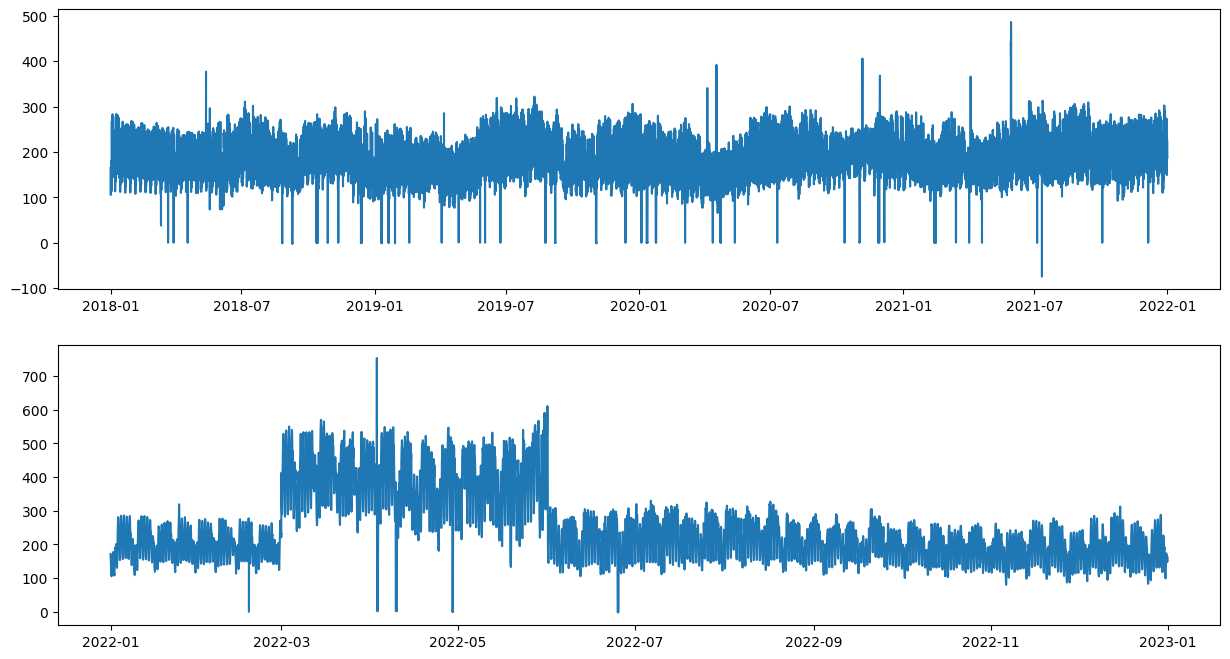

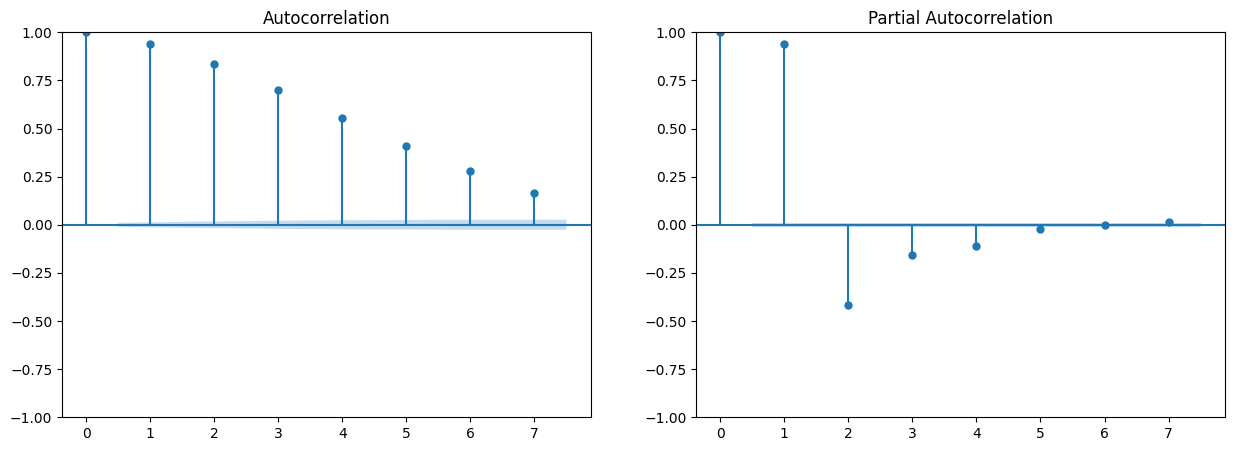

In [20]:
subestacion='CHENA'
filtro="Barra=='{0}'".format(subestacion)
y_buin=ds_train.query(filtro)["Consumo"]
x_buin=ds_train.query(filtro).index
yt_buin=ds_test.query(filtro)["Consumo"]
xt_buin=ds_test.query(filtro).index
fig, axes = plt.subplots(2,1)
fig.set_size_inches(15, 8)
axes[0].plot(x_buin,y_buin);
axes[1].plot(xt_buin,yt_buin);
fig, axes = plt.subplots(1,2)
fig.set_size_inches(15, 5)
plot_acf(y_buin,lags=7,ax=axes[0]);
plot_pacf(y_buin,lags=7,method="ywm",ax=axes[1]);

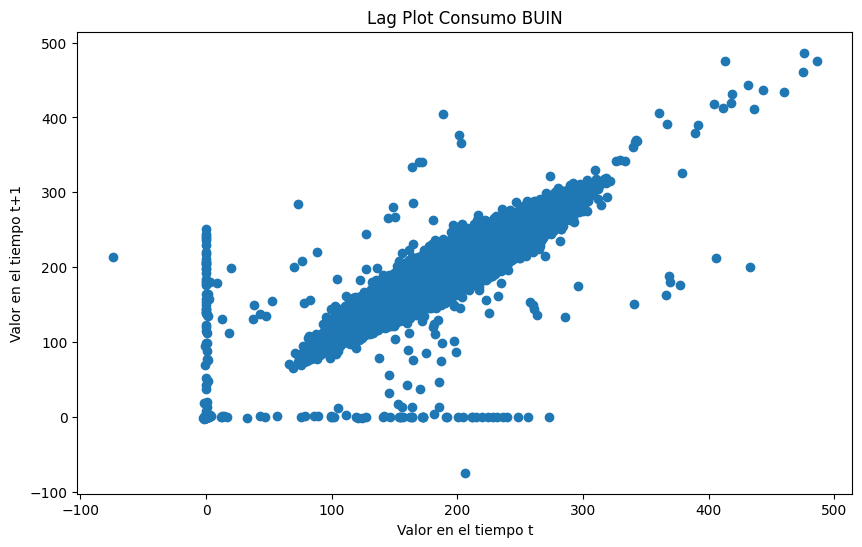

In [21]:
plt.figure(figsize=(10, 6))
lag_plot(y_buin, lag=1)  # Puedes ajustar el valor de 'lag' según tus necesidades
plt.title('Lag Plot Consumo BUIN')
plt.xlabel('Valor en el tiempo t')
plt.ylabel('Valor en el tiempo t+1')
plt.show()

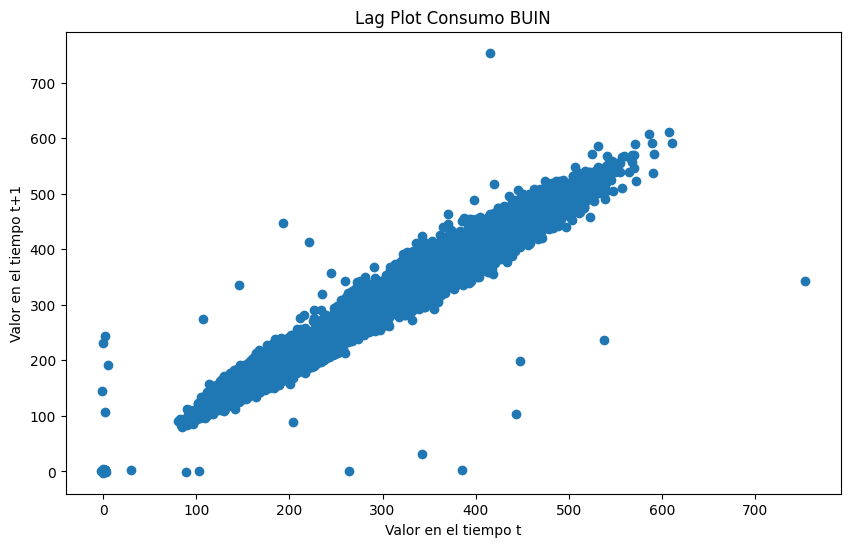

In [22]:
plt.figure(figsize=(10, 6))
lag_plot(yt_buin, lag=1)  # Puedes ajustar el valor de 'lag' según tus necesidades
plt.title('Lag Plot Consumo BUIN')
plt.xlabel('Valor en el tiempo t')
plt.ylabel('Valor en el tiempo t+1')
plt.show()

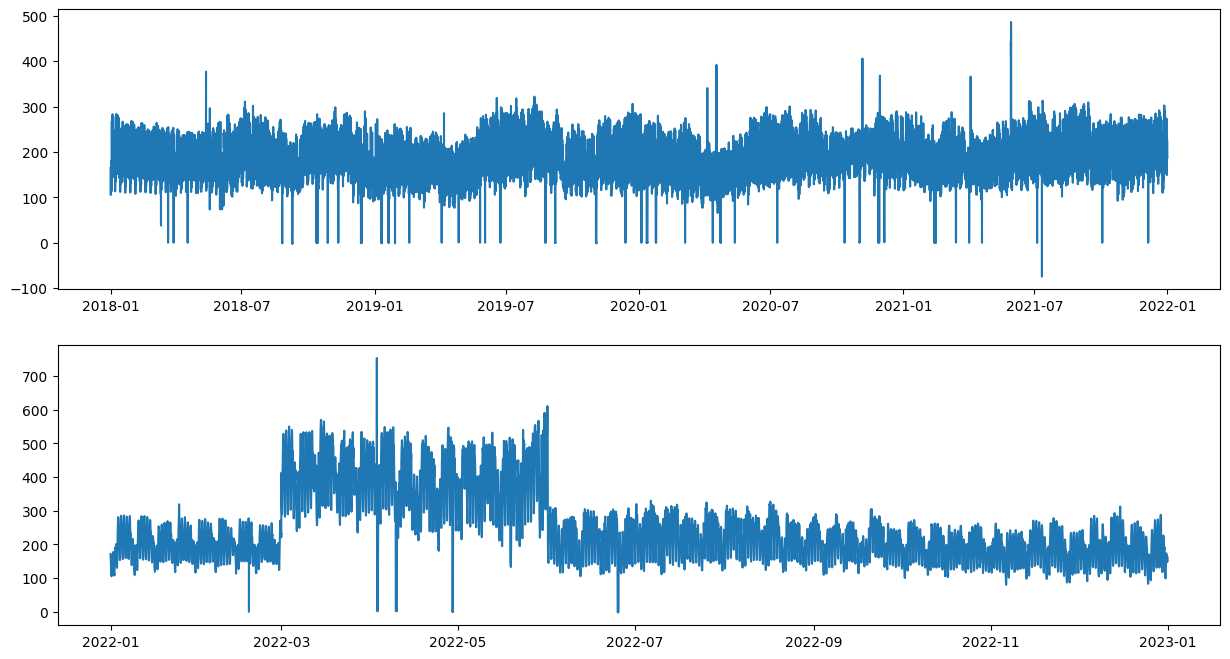

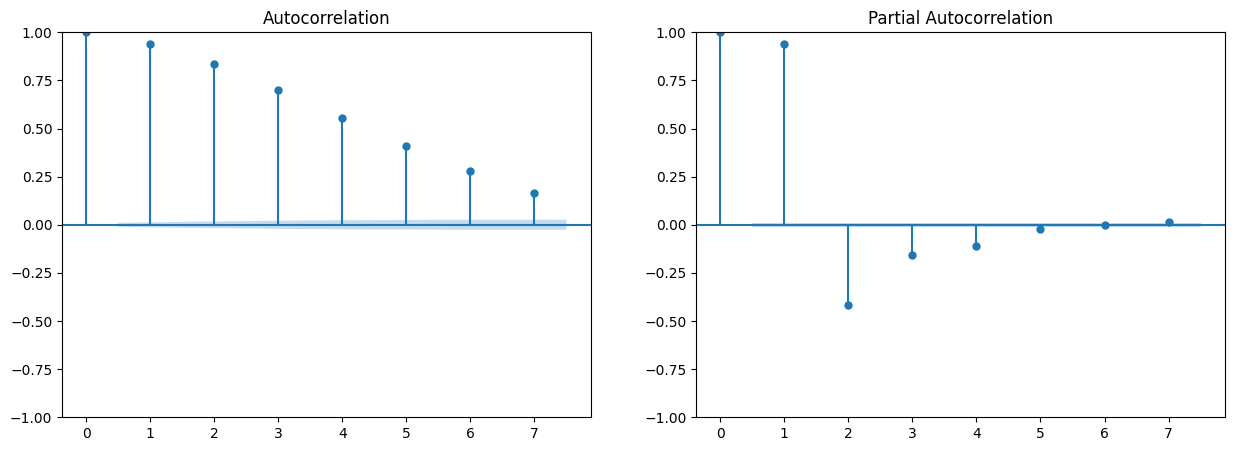

In [23]:
#sin outlayers
subestacion_out='CHENA'
filtro="Barra=='{0}'".format(subestacion_out)
y_buin_out=ds_train_out.query(filtro)["Consumo"]
x_buin_out=ds_train_out.query(filtro).index
yt_buin_out=ds_test_out.query(filtro)["Consumo"]
xt_buin_out=ds_test_out.query(filtro).index
fig, axes = plt.subplots(2,1)
fig.set_size_inches(15, 8)
axes[0].plot(x_buin_out,y_buin_out);
axes[1].plot(xt_buin_out,yt_buin_out);
fig, axes = plt.subplots(1,2)
fig.set_size_inches(15, 5)
plot_acf(y_buin_out,lags=7,ax=axes[0]);
plot_pacf(y_buin_out,lags=7,method="ywm",ax=axes[1]);

<Axes: xlabel='Hora', ylabel='Consumo'>

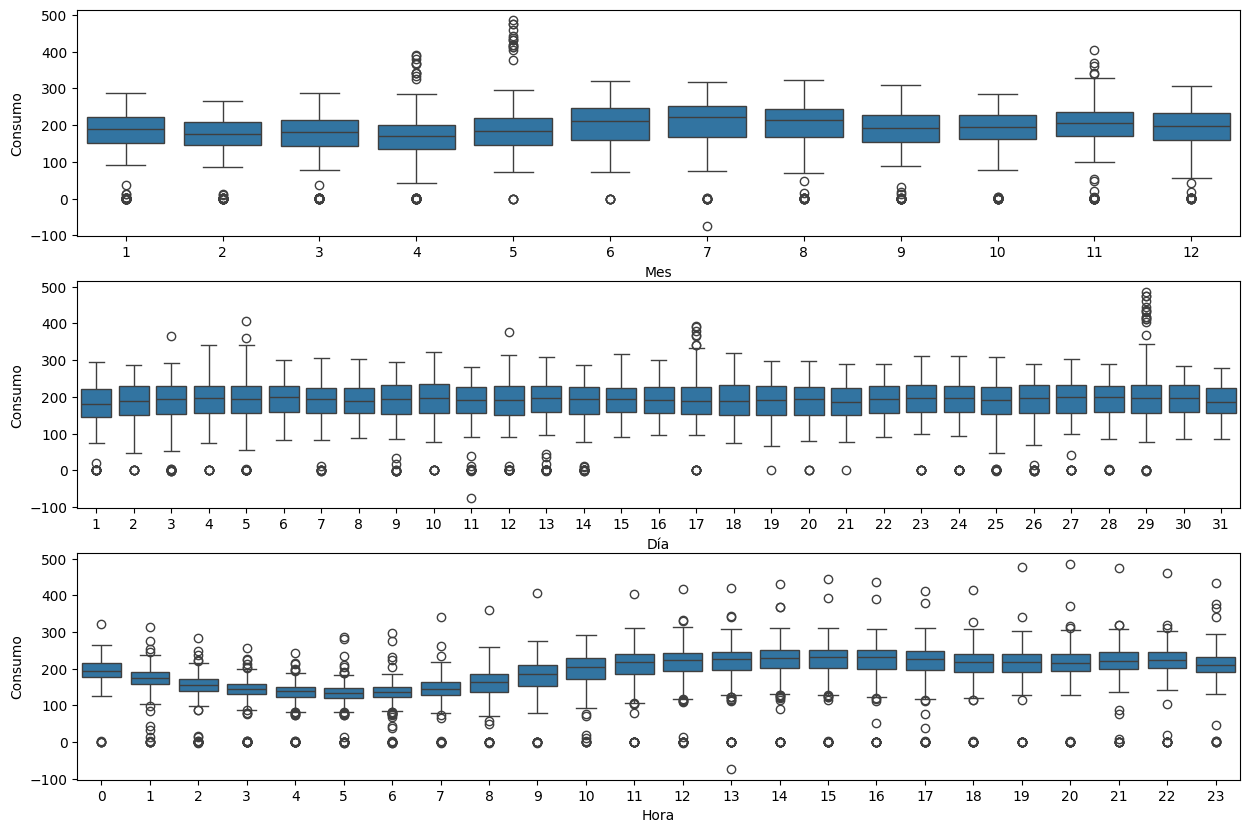

In [24]:
data_buin=pd.DataFrame()
data_buin["Consumo"]=y_buin
data_buin["Date"]=y_buin.index
data_buin["Día"]=data_buin["Date"].dt.day
data_buin["Hora"]=data_buin["Date"].dt.hour
data_buin["Mes"]=data_buin["Date"].dt.month

fig, axes = plt.subplots(3,1)
fig.set_size_inches(15, 10)

sns.boxplot(x="Mes", y="Consumo", data=data_buin, ax=axes[0])
sns.boxplot(x="Día", y="Consumo", data=data_buin, ax=axes[1])
sns.boxplot(x="Hora", y="Consumo", data=data_buin, ax=axes[2])


<Axes: xlabel='Hora', ylabel='Consumo'>

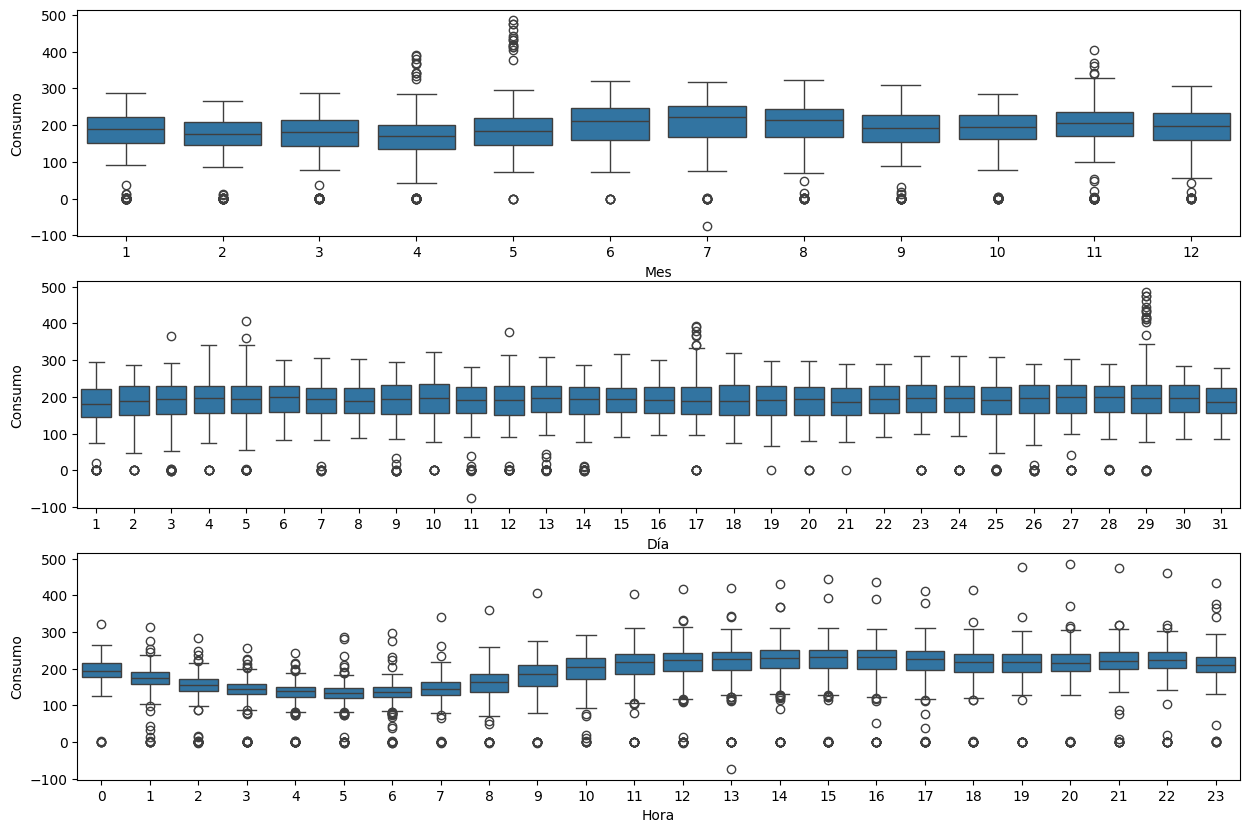

In [25]:
#sin outlayers
data_buin_out=pd.DataFrame()
data_buin_out["Consumo"]=y_buin_out
data_buin_out["Date"]=y_buin_out.index
data_buin_out["Día"]=data_buin_out["Date"].dt.day
data_buin_out["Hora"]=data_buin_out["Date"].dt.hour
data_buin_out["Mes"]=data_buin_out["Date"].dt.month

fig, axes = plt.subplots(3,1)
fig.set_size_inches(15, 10)

sns.boxplot(x="Mes", y="Consumo", data=data_buin_out, ax=axes[0])
sns.boxplot(x="Día", y="Consumo", data=data_buin_out, ax=axes[1])
sns.boxplot(x="Hora", y="Consumo", data=data_buin_out, ax=axes[2])

In [26]:
data_buin["Año"]=data_buin["Date"].dt.year
data_buin

,Consumo,Date,Día,Hora,Mes,Año
Date,,,,,,
2018-01-01 00:00:00,164.664089,2018-01-01 00:00:00,1,0,1,2018
2018-01-01 01:00:00,151.831422,2018-01-01 01:00:00,1,1,1,2018
2018-01-01 02:00:00,148.108589,2018-01-01 02:00:00,1,2,1,2018
2018-01-01 03:00:00,138.904701,2018-01-01 03:00:00,1,3,1,2018
2018-01-01 04:00:00,132.229202,2018-01-01 04:00:00,1,4,1,2018
...,...,...,...,...,...,...
2021-12-31 19:00:00,207.491811,2021-12-31 19:00:00,31,19,12,2021
2021-12-31 20:00:00,195.808645,2021-12-31 20:00:00,31,20,12,2021
2021-12-31 21:00:00,190.696882,2021-12-31 21:00:00,31,21,12,2021


In [27]:
#sin outlayers
data_buin_out["Año"]=data_buin_out["Date"].dt.year
data_buin_out

,Consumo,Date,Día,Hora,Mes,Año
Date,,,,,,
2018-01-01 00:00:00,164.664089,2018-01-01 00:00:00,1,0,1,2018
2018-01-01 01:00:00,151.831422,2018-01-01 01:00:00,1,1,1,2018
2018-01-01 02:00:00,148.108589,2018-01-01 02:00:00,1,2,1,2018
2018-01-01 03:00:00,138.904701,2018-01-01 03:00:00,1,3,1,2018
2018-01-01 04:00:00,132.229202,2018-01-01 04:00:00,1,4,1,2018
...,...,...,...,...,...,...
2021-12-31 19:00:00,207.491811,2021-12-31 19:00:00,31,19,12,2021
2021-12-31 20:00:00,195.808645,2021-12-31 20:00:00,31,20,12,2021
2021-12-31 21:00:00,190.696882,2021-12-31 21:00:00,31,21,12,2021


In [28]:
print(data_buin.columns)

Index(['Consumo', 'Date', 'Día', 'Hora', 'Mes', 'Año'], dtype='object')


In [29]:
print(data_buin_out.columns)

Index(['Consumo', 'Date', 'Día', 'Hora', 'Mes', 'Año'], dtype='object')


In [30]:
data_ys_buin=data_buin[["Año","Mes","Día","Consumo"]].groupby(["Año","Mes","Día"]).agg("mean")
data_ys_buin.to_csv("data_ys_buin.csv")

In [31]:
#sin outlayers
data_ys_buin_out=data_buin_out[["Año","Mes","Día","Consumo"]].groupby(["Año","Mes","Día"]).agg("mean")
data_ys_buin_out.to_csv("data_ys_buin_out.csv")

In [32]:
ys_buin=[]
xs_buin=[]
archivo=open("data_ys_buin.csv")
archivo.readline()
for linea in archivo:
    linea=linea.strip().split(",")
    ys_buin.append(float(linea[3]))
    fecha=str(linea[0])+"-"+str(linea[1]).zfill(2)+"-"+str(linea[2]).zfill(2)
    xs_buin.append(datetime.strptime(fecha,"%Y-%m-%d"))

In [33]:
#sin outlayers
ys_buin_out=[]
xs_buin_out=[]
archivo=open("data_ys_buin_out.csv")
archivo.readline()
for linea in archivo:
    linea=linea.strip().split(",")
    ys_buin_out.append(float(linea[3]))
    fecha=str(linea[0])+"-"+str(linea[1]).zfill(2)+"-"+str(linea[2]).zfill(2)
    xs_buin_out.append(datetime.strptime(fecha,"%Y-%m-%d"))

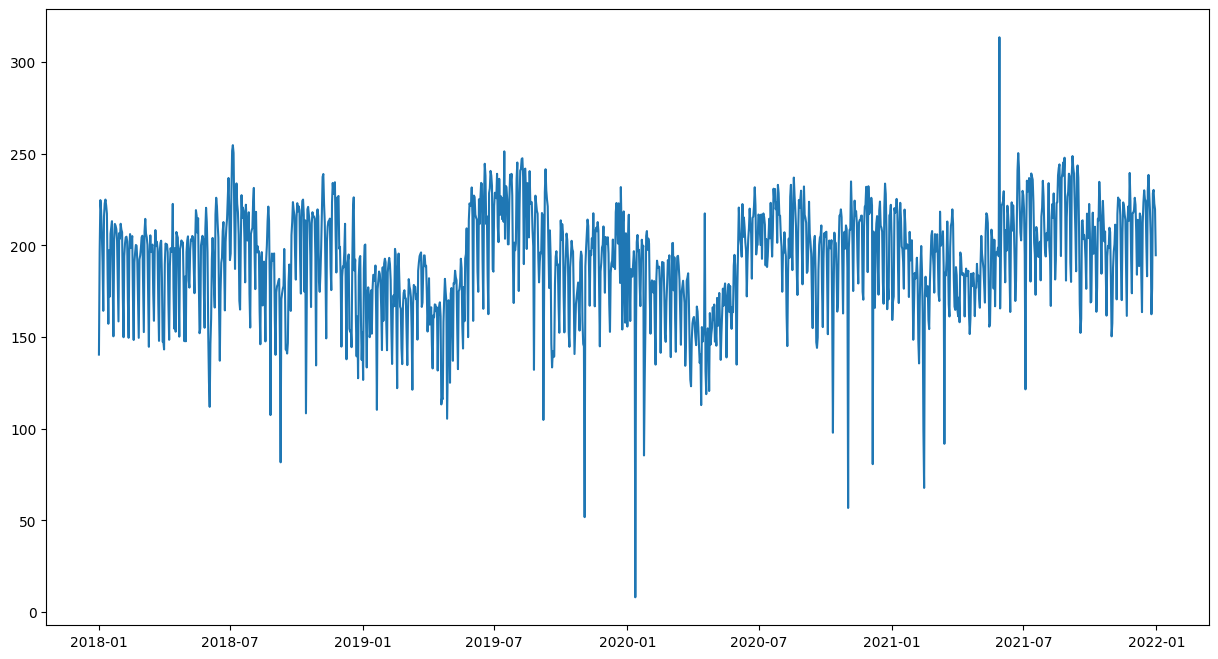

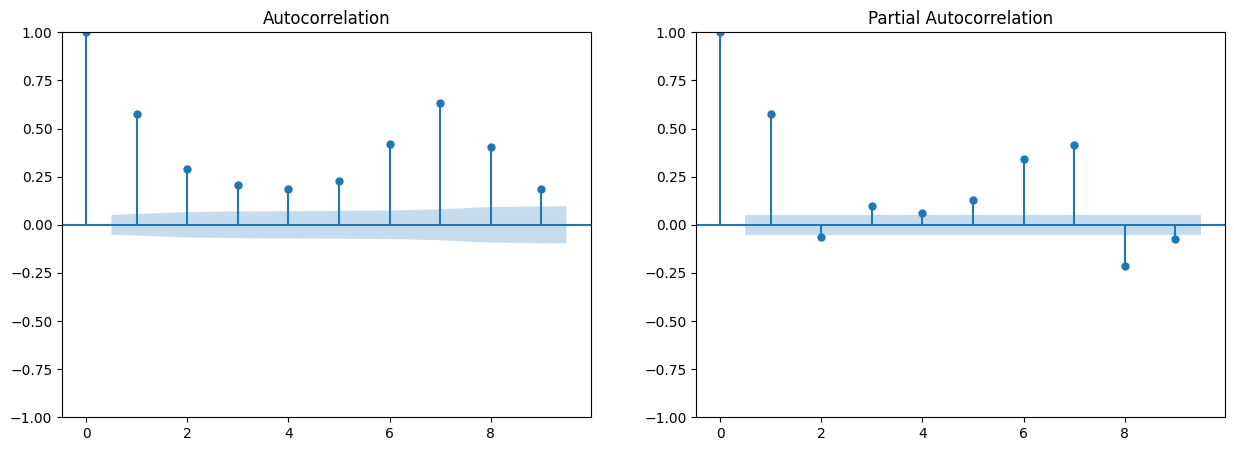

In [34]:
fig, axes = plt.subplots(1,1)
fig.set_size_inches(15, 8)
axes.plot(xs_buin,ys_buin);
fig, axes = plt.subplots(1,2)
fig.set_size_inches(15, 5)
plot_acf(ys_buin,lags=9,ax=axes[0]);
plot_pacf(ys_buin,lags=9,method="ywm",ax=axes[1]);

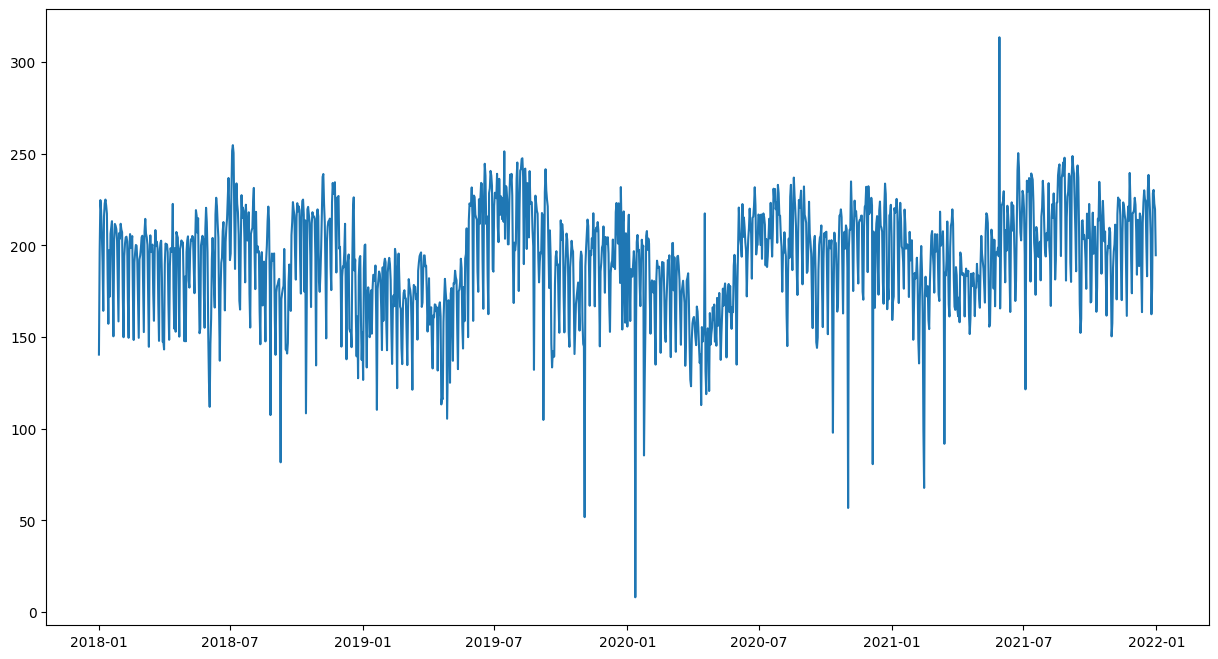

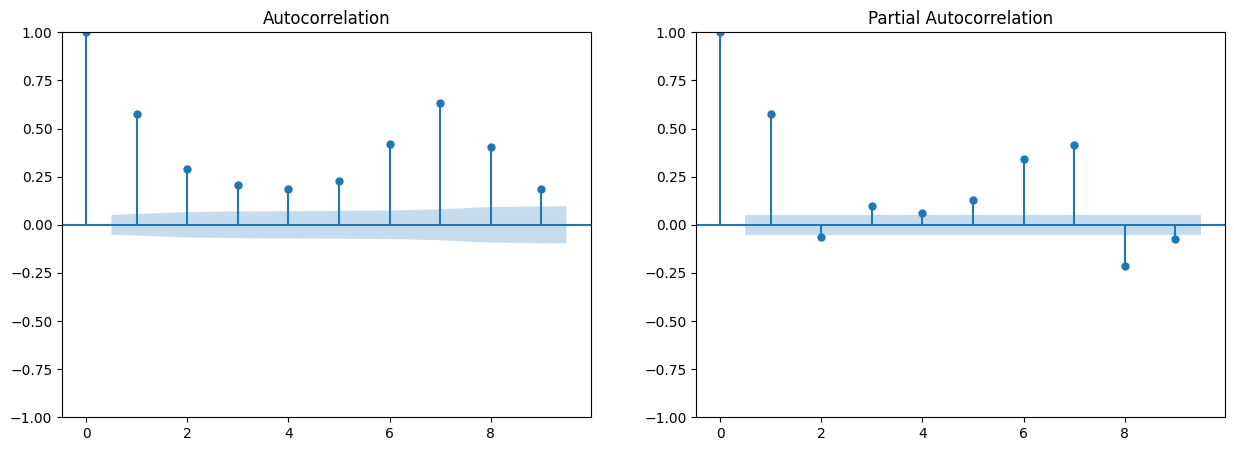

In [35]:
#sin outlayers
fig, axes = plt.subplots(1,1)
fig.set_size_inches(15, 8)
axes.plot(xs_buin_out,ys_buin_out);
fig, axes = plt.subplots(1,2)
fig.set_size_inches(15, 5)
plot_acf(ys_buin_out,lags=9,ax=axes[0]);
plot_pacf(ys_buin_out,lags=9,method="ywm",ax=axes[1]);

In [36]:
result = kpss(ys_buin)

# Imprimir los resultados
print('KPSS Statistic:', result[0])
print('p-value:', result[1])
def funcion(x):
    if x<0.05:
        print("La serie no es estacionaria")
    else:
        print("La serie es estacionaria")
funcion(result[1])

KPSS Statistic: 0.6375952173954318
p-value: 0.019218616600415288
La serie no es estacionaria


In [37]:
#sin outlayers
result = kpss(ys_buin_out)

# Imprimir los resultados
print('KPSS Statistic:', result[0])
print('p-value:', result[1])
def funcion(x):
    if x<0.05:
        print("La serie no es estacionaria")
    else:
        print("La serie es estacionaria")
funcion(result[1])

KPSS Statistic: 0.6375952173954318
p-value: 0.019218616600415288
La serie no es estacionaria


In [38]:
modelo_buin_d=ARIMA(ys_buin,order=(1,0,1))
m_ad1=modelo_buin_d.fit()
print("MSE",m_ad1.mse)
print("AIC",m_ad1.aic)
ysp_buin=m_ad1.predict()
mape=mean_absolute_percentage_error(ys_buin,ysp_buin)
print("MAPE",mape)

MSE 551.5837480499827
AIC 13375.940929309374
MAPE 0.11512180095776448


In [39]:
modelo_buin_d=ARIMA(ys_buin,order=(8,0,8))
m_ad1=modelo_buin_d.fit()
print("MSE",m_ad1.mse)
print("AIC",m_ad1.aic)
ysp_buin=m_ad1.predict()
mape=mean_absolute_percentage_error(ys_buin,ysp_buin)
print("MAPE",mape)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MSE 292.73883536096196
AIC 12478.57760386588
MAPE 0.07832979719688422


In [40]:
#sin outlayers
modelo_buin_d_out=ARIMA(ys_buin_out,order=(8,0,8))
m_ad1_out=modelo_buin_d_out.fit()
print("MSE",m_ad1_out.mse)
print("AIC",m_ad1_out.aic)
ysp_buin_out=m_ad1_out.predict()
mape_out=mean_absolute_percentage_error(ys_buin_out,ysp_buin_out)
print("MAPE",mape_out)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MSE 292.73883536096196
AIC 12478.57760386588
MAPE 0.07832979719688422


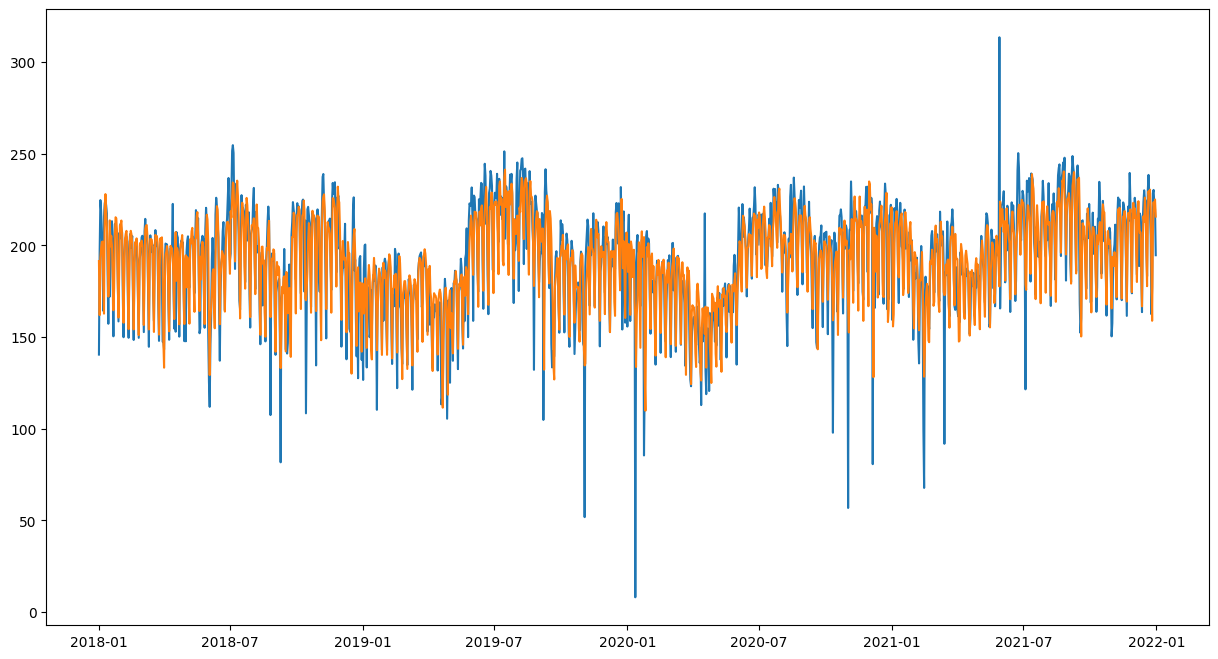

In [41]:
fig, axes = plt.subplots(1,1)
fig.set_size_inches(15, 8)
axes.plot(xs_buin,ys_buin,xs_buin,ysp_buin);

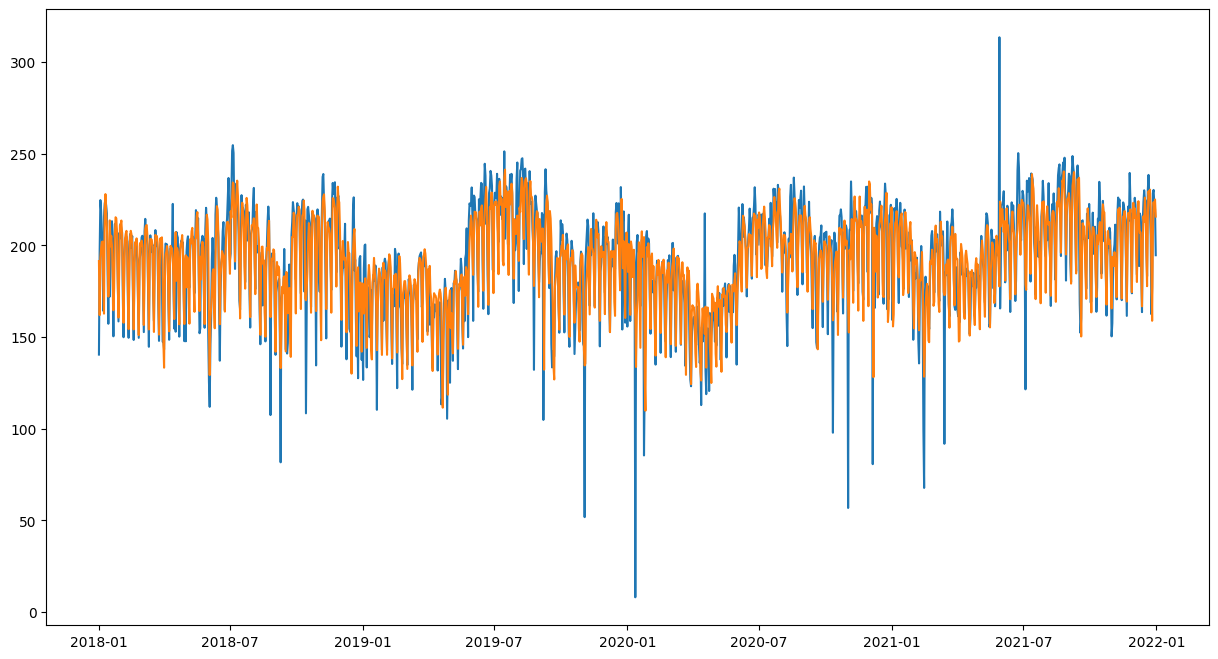

In [42]:
#sin outlayers
fig, axes = plt.subplots(1,1)
fig.set_size_inches(15, 8)
axes.plot(xs_buin_out,ys_buin_out,xs_buin_out,ysp_buin_out);

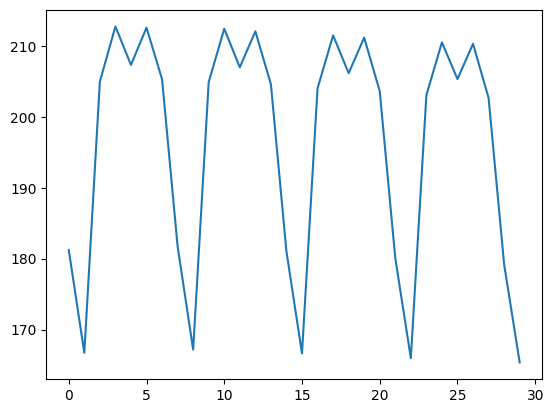

In [43]:
m1_y1_p = m_ad1.get_forecast(steps=30)
m1_y1_ci = m_ad1.conf_int(0.05)
plt.plot(m1_y1_p.predicted_mean)

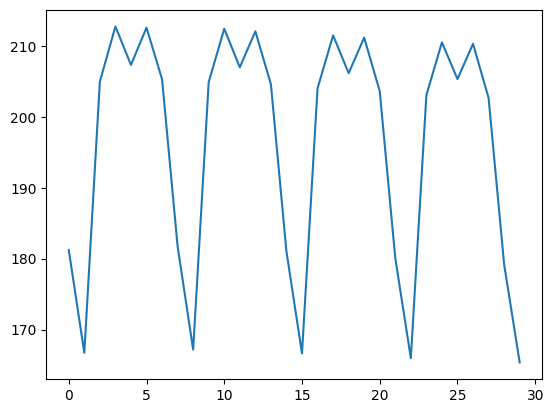

In [44]:
#sin outlayers
m1_y1_p_out = m_ad1_out.get_forecast(steps=30)
m1_y1_ci_out = m_ad1_out.conf_int(0.05)
plt.plot(m1_y1_p_out.predicted_mean)

In [45]:
yw_buin=[]
yt_buin=[]
window=8
for i in range(0,len(ys_buin)):
    if i+window < len(ys_buin):
        row=[]
        for j in range(window):
            row.append(ys_buin[i+j])
        yw_buin.append(row)
        yt_buin.append(ys_buin[i+window])
    else:
        break
print(len(yw_buin))

1453


In [46]:
#sin outlayers
yw_buin_out=[]
yt_buin_out=[]
window=8
for i in range(0,len(ys_buin_out)):
    if i+window < len(ys_buin_out):
        row=[]
        for j in range(window):
            row.append(ys_buin_out[i+j])
        yw_buin_out.append(row)
        yt_buin_out.append(ys_buin_out[i+window])
    else:
        break
print(len(yw_buin_out))

1453


In [47]:
yw_buin=np.asarray(yw_buin)
yt_buin=np.asarray(yt_buin)

In [48]:
#sin outlayers
yw_buin_out=np.asarray(yw_buin_out)
yt_buin_out=np.asarray(yt_buin_out)

In [49]:
import tensorflow as tf
from datetime import datetime
from keras.layers import SimpleRNN, Input, Dense
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import random as rd

In [50]:
seed=12122009
rd.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [51]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='mape', patience=30, restore_best_weights=True)

model_buin = Sequential()
model_buin.add(Input(name="serie",shape=(8,1)))
model_buin.add(SimpleRNN(300))
model_buin.add(Dense(130))
model_buin.add(Dense(1, activation='linear'))
model_buin.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 300)               90600     
                                                                 
 dense (Dense)               (None, 130)               39130     
                                                                 
 dense_1 (Dense)             (None, 1)                 131       
                                                                 
Total params: 129861 (507.27 KB)
Trainable params: 129861 (507.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [52]:
#Sin outliyers
model_buin_out = Sequential()
model_buin_out.add(Input(name="serie",shape=(8,1)))
model_buin_out.add(SimpleRNN(300))
model_buin_out.add(Dense(128))
model_buin_out.add(Dense(1, activation='linear'))
model_buin_out.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 300)               90600     
                                                                 
 dense_2 (Dense)             (None, 128)               38528     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 129257 (504.91 KB)
Trainable params: 129257 (504.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
tag="rnn"+datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/" + tag
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
optimizer=Adam(learning_rate=1e-3)

callbacks = [tensorboard_callback, early_stopping]
model_buin.compile(optimizer="Adam", loss='mse', metrics=['mse','mae','mape'])
rnn = model_buin.fit(yw_buin, yt_buin, batch_size=300, epochs=500, verbose=1, callbacks=callbacks)
model_buin.save(log_dir + '/model_{0}.keras'.format(tag))

Epoch 1/500
5/5 [==============================] - 2s 94ms/step - loss: 34877.3516 - mse: 34877.3516 - mae: 184.4348 - mape: 96.2337
Epoch 2/500
5/5 [==============================] - 0s 66ms/step - loss: 27546.3340 - mse: 27546.3340 - mae: 163.3997 - mape: 85.1619
Epoch 3/500
5/5 [==============================] - 0s 64ms/step - loss: 20965.9004 - mse: 20965.9004 - mae: 141.7803 - mape: 73.7051
Epoch 4/500
5/5 [==============================] - 0s 66ms/step - loss: 15018.3828 - mse: 15018.3828 - mae: 119.0169 - mape: 61.5819
Epoch 5/500
5/5 [==============================] - 0s 66ms/step - loss: 9830.8838 - mse: 9830.8838 - mae: 94.9751 - mape: 49.0621
Epoch 6/500
5/5 [==============================] - 0s 68ms/step - loss: 5728.9561 - mse: 5728.9561 - mae: 70.5123 - mape: 36.6038
Epoch 7/500
5/5 [==============================] - 0s 96ms/step - loss: 2891.1194 - mse: 2891.1194 - mae: 47.5369 - mape: 24.9596
Epoch 8/500
5/5 [==============================] - 1s 114ms/step - loss: 1349.

In [ ]:
xw_buin=[i for i in range(len(yw_buin))]
yp_buin=model_buin.predict(yw_buin)
plt.plot(xw_buin,yw_buin,xw_buin,yp_buin)

In [ ]:
ultimo_buin=list(yw_buin[-1].copy())
forecasts=[]
for i in range(30):
    data_buin=np.array(np.asarray([ultimo_buin]))
    forecast=model_buin.predict(data_buin)
    valor=forecast[0][0]
    print(valor)
    forecasts.append(valor)
    ultimo_buin.pop(0)
    ultimo_buin.append(valor)
plt.plot(forecasts)

In [ ]:
#entrega de datos desordenados
tag="rnn"+datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/" + tag
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
optimizer=Adam(learning_rate=1e-3)

callbacks = [tensorboard_callback, early_stopping]
model_buin.compile(optimizer="Adam", loss='mse', metrics=['mse','mae','mape'])
rnn = model_buin.fit(yw_buin, yt_buin, batch_size=300, epochs=500,shuffle=True,verbose=1,callbacks=callbacks)
model_buin.save(log_dir+'/model_{0}.keras'.format(tag))

In [ ]:
xw_buin=[i for i in range(len(yw_buin))]
yp=model_buin.predict(yw_buin)
plt.plot(xw_buin,yw_buin,xw_buin,yp_buin)

In [ ]:
ultimo_buin=list(yw_buin[-1].copy())
forecasts=[]
for i in range(30):
    data_buin=np.array(np.asarray([ultimo_buin]))
    forecast=model_buin.predict(data_buin)
    valor=forecast[0][0]
    print(valor)
    forecasts.append(valor)
    ultimo_buin.pop(0)
    ultimo_buin.append(valor)
plt.plot(forecasts)

In [ ]:
yt_buin=ds_test.query(filtro)["Consumo"]
xt_buin=ds_test.query(filtro).index
plt.plot(xt_buin[:30],yt_buin[:30])

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import numpy as np

# Aplicar el filtro para la subestación 'BUIN'
subestacion = 'CHENA'
filtro = "Barra=='{0}'".format(subestacion)
filtered_ds_train = ds_train.query(filtro)
filtered_ds_test = ds_test.query(filtro)

# Obtener características (X) y etiquetas (y) para entrenamiento y prueba
X_train_buin = filtered_ds_train.drop(columns=['Consumo'])
y_train_buin = filtered_ds_train['Consumo']
X_test_buin = filtered_ds_test.drop(columns=['Consumo'])
y_test_buin = filtered_ds_test['Consumo']

# Crear el preprocesador para codificar la variable categórica 'Barra' usando OneHotEncoder
column_transformer = ColumnTransformer([('encoder', OneHotEncoder(), ['Barra'])], remainder='passthrough')
X_train_buin_encoded = column_transformer.fit_transform(X_train_buin)
X_test_buin_encoded = column_transformer.transform(X_test_buin)

# Crear el modelo MLPRegressor
mlp_regressor_buin = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=1000)

# Entrenar el modelo MLPRegressor
mlp_regressor_buin.fit(X_train_buin_encoded, y_train_buin)

# Realizar predicciones en el conjunto de prueba
y_pred_buin = mlp_regressor_buin.predict(X_test_buin_encoded)

# Calcular el error cuadrático medio
mse_buin = mean_squared_error(y_test_buin, y_pred_buin)
print("Error cuadrático medio (MSE):", mse_buin)


# Calcular el coeficiente de determinación (R^2)
r2_buin = r2_score(y_test_buin, y_pred_buin)
print("Coeficiente de determinación (R^2):", r2_buin)


# Calcular el error absoluto medio (MAE)
mae_buin = mean_absolute_error(y_test_buin, y_pred_buin)
print("Error absoluto medio (MAE):", mae_buin)


# Calcular el Error Porcentual Absoluto Medio (MAPE)
epsilon = 1e-10
mape_buin = np.mean(np.abs((y_test_buin - y_pred_buin) / (y_test_buin + epsilon))) * 100
print("Error Porcentual Absoluto Medio (MAPE):", mape_buin)




In [ ]:
y_train_buin

In [ ]:
print(y_train_buin.head())

In [ ]:
print(y_test_buin.head())

In [ ]:
print(X_train_buin.head())
print(y_train_buin.head())
print(X_test_buin.head())
print(y_test_buin.head())

In [ ]:
print(X_train_buin.dtypes)
print(y_train_buin.dtypes)
print(X_test_buin.dtypes)
print(y_test_buin.dtypes)

In [ ]:
#corregir para la parte 2
percentiles = consumo['Consumo'].describe(percentiles=[0.25, 0.5, 0.75])

print("\nPercentiles:")
print(percentiles)

In [ ]:
# corregir gráfico
plt.figure(figsize=(8, 6))
plt.scatter(consumo['Consumo'], consumo['Consumo'])
plt.title('Gráfico de Lag (Consumo t vs. Consumo t-1)')
plt.xlabel('Consumo en el tiempo t-1')
plt.ylabel('Consumo en el tiempo t')
plt.grid(True)
plt.show()

In [ ]:
#corregir gráfico
plt.figure(figsize=(8, 6))
sns.scatterplot(x=consumo['Consumo'].shift(1), y=consumo['Consumo'])
plt.title('Gráfico de Lag')
plt.xlabel('Consumo en el tiempo t-1')
plt.ylabel('Consumo en el tiempo t')
plt.show()